<a href="https://colab.research.google.com/github/anasali0006/FaceForesics-Deepfakes-Detection/blob/main/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import pickle
#import cv2
from google.colab.patches import cv2_imshow
#import PIL
import datetime
import os

In [ ]:
!pip install wandb
import wandb
wandb.init()

GPU Status

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()



In [ ]:
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

Gen RAM Free: 12.8 GB  | Proc size: 113.0 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


**Getting the video data from drive**


In [ ]:
!cp -r /content/drive/MyDrive/ML-DeepFakes-Detection/saved-arrays /content/video_data

In [ ]:
#load real images
dir='/content/video_data/'
real='real'
fake='fake'
real_array=np.zeros((1,100,100,3))
for i in range(1,25):
  dir_real=dir + real + str(i)
  with open(dir_real, 'rb') as f:
    new_array = pickle.load(f)
  truncated_array = new_array[1:,:,:,:]
  real_array=np.append(real_array, truncated_array, axis=0)
  
real_array=real_array[1:,:,:,:]
  # Python 3: open(..., 'rb')
f.close()

In [ ]:
#load fake images
dir='/content/video_data/'
real='real'
fake='fake'
fake_array=np.zeros((1,100,100,3))
for i in range(1,25):
  dir_fake=dir + fake + str(i)
  with open(dir_fake, 'rb') as f:
    new_array = pickle.load(f)
  truncated_array = new_array[1:,:,:,:]
  fake_array=np.append(fake_array, truncated_array, axis=0)
  
fake_array=fake_array[1:,:,:,:]
f.close()

**Preprocessing the Data**

In [ ]:
#real images are labelled 1
#fake images are labelled 0

real_label=np.ones((len(real_array)))
fake_label=np.zeros((len(fake_array)))


In [ ]:
train_examples=np.vstack([real_array, fake_array])
train_labels0=np.hstack([real_label, fake_label])
train_labels=tf.keras.utils.to_categorical(train_labels0, num_classes=2)

In [ ]:
print(train_labels)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
#delete the redundant variables to free up ram
del(real_array)
del(fake_array)
del(real_label)
del(fake_label)

**Converting numpy arrays into Tensors**

In [ ]:
train_tensor_examples=tf.convert_to_tensor(train_examples)
train_tensor_labels=tf.convert_to_tensor(train_labels)

In [ ]:
train_tensor_labels.get_shape()

TensorShape([11106, 2])

**Creating Dataset**

In [ ]:
#converting to tf.data.Dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensor_examples, train_tensor_labels))
#train_dataset.element_spec

In [ ]:
del(train_labels0)
del(train_examples)
del(train_labels)
del(train_tensor_examples)
del(train_tensor_labels)

**Shuffling the Data**

In [ ]:
train_dataset=train_dataset.shuffle(buffer_size=1000, seed=123 )

**Creating Validation and Train split**

In [ ]:
#make validation and training split
#taking 1000 images for validation
val_data=train_dataset.take(1000)
train_dataset=train_dataset.skip(1000)

**Creating Batches**

In [ ]:
train_dataset=train_dataset.batch(batch_size=32)
val_data=val_data.batch(32)

In [ ]:
#checking the shapes of dataset
for x, y in train_dataset:
  print (x.shape)
  print (y.shape)
  break

(32, 100, 100, 3)
(32, 2)


**Visualizing the Data**

In [ ]:
#visualizing the data
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([labels[i]])
    plt.axis("off")


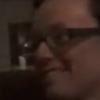

In [ ]:
cv2_imshow(images[5].numpy())

**Importing the Model**

In [ ]:
from tensorflow.keras.applications import Xception
base_model=Xception( include_top=False, weights='imagenet')

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
len(base_model.layers)

132

Set all the layers to non trainable except the final layer. 

In [ ]:
base_model.trainable=False
  

In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

**Model Graph**

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import Resizing
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D


input = Input(shape=(100,100,3))

x = Rescaling(1./255) (input)
x = base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax') (x)

model=tf.keras.Model(input, output)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
rescaling_4 (Rescaling)      (None, 100, 100, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 4,098
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
%load_ext tensorboard

In [ ]:
rm -rf ./logs/

In [ ]:
from tensorflow.keras.optimizers import Adam
opt= Adam(learning_rate=0.002)

model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
model.fit(train_dataset,
          validation_data=val_data,
          batch_size=32,
          epochs=3,  
          )

Epoch 1/3
316/316 [==============================] - 23s 43ms/step - loss: 0.1552 - accuracy: 0.9557 - val_loss: 6.9160 - val_accuracy: 0.0000e+00
Epoch 2/3
316/316 [==============================] - 12s 37ms/step - loss: 0.6802 - accuracy: 0.8601 - val_loss: 7.4239 - val_accuracy: 0.0000e+00
Epoch 3/3
316/316 [==============================] - 12s 37ms/step - loss: 0.6895 - accuracy: 0.8580 - val_loss: 7.5109 - val_accuracy: 0.0010


In [ ]:
base_model.trainable=True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 20,865,578
Trainable params: 20,811,050
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "/content/drive/MyDrive/ML-DeepFakes-Detection/saved_model/training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 32

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=50*316)



# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

In [ ]:
model.fit(train_dataset,
          validation_data=val_data,
          batch_size=32,
          epochs=500,  
          callbacks=[cp_callback])

Epoch 1/500
316/316 [==============================] - 12s 37ms/step - loss: 0.0959 - accuracy: 0.9723 - val_loss: 5.3000 - val_accuracy: 0.1630
Epoch 2/500
316/316 [==============================] - 12s 37ms/step - loss: 0.1424 - accuracy: 0.9619 - val_loss: 5.6834 - val_accuracy: 0.1580
Epoch 3/500
316/316 [==============================] - 12s 37ms/step - loss: 0.1392 - accuracy: 0.9661 - val_loss: 5.3210 - val_accuracy: 0.1850
Epoch 4/500
316/316 [==============================] - 12s 38ms/step - loss: 0.1349 - accuracy: 0.9656 - val_loss: 5.9924 - val_accuracy: 0.1580
Epoch 5/500
316/316 [==============================] - 12s 37ms/step - loss: 0.1537 - accuracy: 0.9643 - val_loss: 5.7114 - val_accuracy: 0.1800
Epoch 6/500
316/316 [==============================] - 12s 37ms/step - loss: 0.1519 - accuracy: 0.9629 - val_loss: 5.5588 - val_accuracy: 0.1760
Epoch 7/500
316/316 [==============================] - 12s 37ms/step - loss: 0.1389 - accuracy: 0.9643 - val_loss: 5.3271 - val_ac

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/ML-DeepFakes-Detection/saved_model/run1.h5',save_format='h5')

In [ ]:
model.fit(train_dataset,
          validation_data=val_data,
          batch_size=32,
          epochs=1000,  
          callbacks=[tensorboard_callback])

In [ ]:
model.fit(train_dataset,
          validation_data=val_data,
          batch_size=32,
          epochs=1000,  
          callbacks=[tensorboard_callback])

Testing


In [ ]:
with open('/content/video_data/fake1', 'rb') as f:
    new_array = pickle.load(f)
f.close()
new_array=new_array[1:,:,:,:]
x=np.array([1,0])
print(new_array.shape)
new_label=np.zeros((len(new_array)))
print(new_label.shape)

(300, 100, 100, 3)
(300,)


In [ ]:
test_labels=np.hstack([new_label])
l=tf.keras.utils.to_categorical(test_labels, num_classes=2)


In [ ]:
tensor=tf.convert_to_tensor(new_array)
label=tf.convert_to_tensor(l)
model.evaluate(tensor,label)

10/10 [==============================] - 1s 52ms/step - loss: 4.9303e-07 - accuracy: 1.0000


[4.930301997774222e-07, 1.0]

In [ ]:
model(tensor)

**Testing on a random video**

In [ ]:
import dlib
from google.colab.patches import cv2_imshow
detector = dlib.get_frontal_face_detector()
import cv2

In [ ]:
#video is fake. Lets see how model predicts
!mkdir test-vid
! cp /content/drive/MyDrive/ML-DeepFakes-Detection/Kaggle_Dataset/extracted/dfdc_train_part_18/baeajscskm.mp4 /content/test-vid/fake.mp4

In [ ]:
fake_vid=np.zeros((1,100,100,3))
  #dir= directory + str(i) + '.mp4'
  #print(dir)  
  #fake_vid=video_to_file(dir, fake_vid)
dir='/content/test-vid/fake.mp4'
video_cap=cv2.VideoCapture(dir)
while(video_cap.isOpened()):
  ret,frame=video_cap.read()
  if (ret==False):
    break
  face = detector(frame, 1)
  if (len(face)):
    face=face[0]
    crop_img=frame[face.top():face.bottom(),face.left():face.right()]
    crop_img=cv2.resize(crop_img,(100,100))
      #cv2_imshow(crop_img)
    crop_img = np.array(crop_img)
    cropped = np.expand_dims(crop_img, axis=0)
    fake_vid=np.append(fake_vid, cropped, axis=0)

In [ ]:
new_array=fake_vid[1:,:,:,:]
x=np.array([1,0])
print(new_array.shape)
new_label=np.zeros((len(new_array)))
print(new_label.shape)

test_labels=np.hstack([new_label])
l=tf.keras.utils.to_categorical(test_labels, num_classes=2)
tensor=tf.convert_to_tensor(new_array)
label=tf.convert_to_tensor(l)
model.evaluate(tensor,label)

(293, 100, 100, 3)
(293,)
10/10 [==============================] - 1s 54ms/step - loss: 1.8945 - accuracy: 0.6792


[1.8944752216339111, 0.6791808605194092]

In [ ]:
model(tensor)